## Proba-V Time-Series Analysis
**Author:** René Kopeinig<br>
**Description:** Basic Time-Series Analysis using Proba-V NDVI (Normalized Difference Vegetation Index) imagery.

In [48]:
%matplotlib inline

In [70]:
from IPython.display import Image
import ee, datetime
import pandas as pd
from pylab import *
import seaborn as sns
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose

ee.Initialize()

### Load Proba-V image collection and a point geometry
Selected Location of point is from the Proba-V Footprint X18Y02 in Luxembourg, Europe. 

In [71]:
# Set start and end date
startTime = datetime.datetime(2015, 1, 1)
endTime = datetime.datetime(2017, 12, 31)

# Create image collection
collection = ee.ImageCollection('VITO/PROBAV/C1/S1_TOC_100M').filterDate(startTime, endTime)
# Create point in Luxembourg (Proba-V Footprint: X18Y02)
point = {'type':'Point', 'coordinates':[6.134136, 49.612485]};

### Retrieve information, reshape and calculate NDVI
Retrieving information from point geometry with a buffer of 500m over image collection. Reshaping data and calculating NDVI from **RED** and **NIR** band.

In [72]:
info = collection.getRegion(point,500).getInfo()

In [73]:
# Reshape image collection 
header = info[0]
data = array(info[1:])

iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

# List of used image bands
band_list = ['RED',u'NIR']

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)

# Calculate NDVI
red = yData[:,0]
nir = yData[:,1]
ndvi = (nir - red) / (nir + red)

### Reshape NDVI array into Pandas Dataframe

In [74]:
df = pd.DataFrame(data=ndvi, index=list(range(len(ndvi))), columns=['NDVI'])
df = df.interpolate()
df['Date'] = pd.Series(time, index=df.index)
df = df.set_index(df.Date)
df.index = pd.to_datetime(df.index)
df['NDVI']=df['NDVI'].fillna(0)

### Obtain statistical information over all elements of the Time-Series

In [114]:
df.describe()

,NDVI
count,1089.000000
mean,0.161247
std,0.160562
min,-0.126732
25%,0.032688
50%,0.106697
75%,0.262921
max,0.633987


### Visualize Proba-V NDVI Time Series

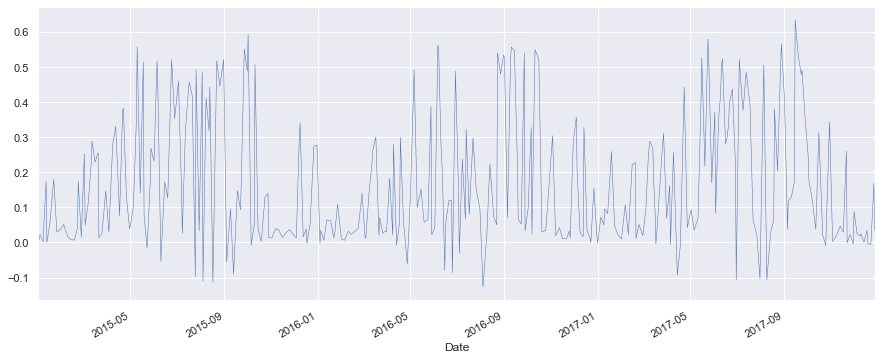

In [115]:
sns.set(rc={'figure.figsize':(15, 6)})
df['NDVI'].plot(linewidth=0.5);

### Seasonal Decomposition

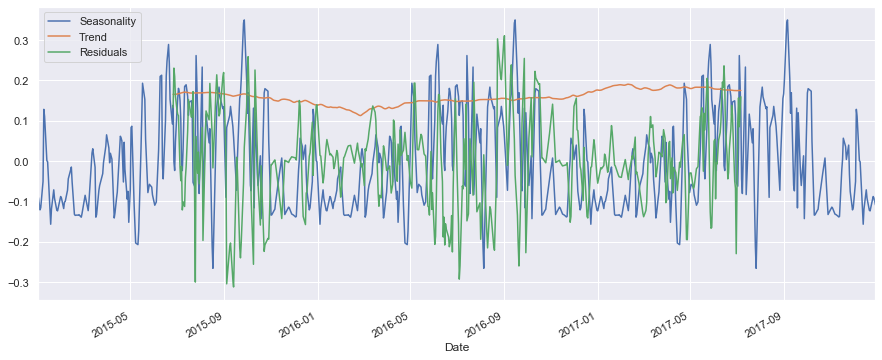

In [116]:
sd=seasonal_decompose(df['NDVI'], model='additive', freq=352)

sd.seasonal.plot()
sd.trend.plot()
sd.resid.plot()
plt.legend(['Seasonality', 'Trend', 'Residuals'])

### Resample data
Resampling to weekly level and calculate the percentage change over one year.

/Users/rkopei/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, '52 Weeks Percentage Change')

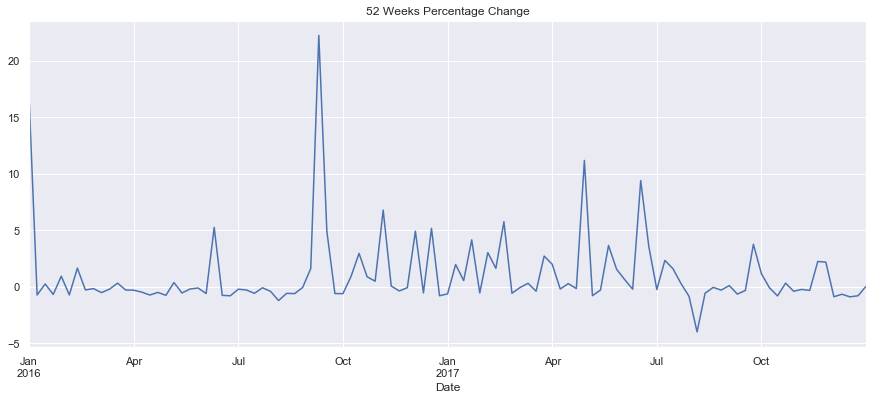

In [117]:
df_monthly=df.resample('W', 'mean')
df_monthly['pct_change'] = df_monthly.pct_change(52)
df_monthly['pct_change']['2016':].plot()
plt.title('52 Weeks Percentage Change')